## Analysis of trading the S&P 500 stocks in 2019 with technical analysis and machine learning by Will Sharp

This project's goal is to see how well certain technical analysis strategies work on trading the S&P 500 stocks in a year, and how much it would lose or make the user money. The technical analysis is also paired with a machine learning algorithm that tells the simulation to only buy a stock if the confidence in that stock is above a certain threshold. To start, I will pull all the stock data from 2019 of the S&P 500 stocks from yahoo finance and simulate a whole year of trading with buy/sell indicators that will be be overlayed on stock charts and explained throughout the project. I will place all the stocks into their own .csv files as well into a dateframe to run a machine learning algorithm. The goal of this project is to see if these trading strategies are a viable option to implement into your own portfolio by comparing our results to the general market gain of the S&P 500 in 2019, which according to Forbes was 29%.


In [1430]:
import pandas as pd
import bs4 as bs
import os
import pickle
import requests
import datetime as dt
import yfinance as finance
import pandas_datareader.data as web
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import svm, neighbors
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

style.use('ggplot')

import matplotlib.dates as mdates
import numpy as np

def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text)
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip()

        tickers.append(ticker)
    
    

    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)

    tickers1 = []
    for ticker in tickers:
        replaced = ticker.replace(".", "-")
        tickers1.append(replaced)



    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers1, f)
    
    return tickers1

#save_sp500_tickers()




def get_data(reload_sp500 = False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2019,1,1)
    end = dt.datetime(2019,12,31)
    for ticker in tickers:
        print(ticker)
        if not ticker == 'CARR':
            if not ticker == 'LUMN':
                if not ticker == 'OTIS':
                    if not ticker == 'VNT':
                        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
                            df = web.DataReader(ticker, 'yahoo', start, end)
                            df.to_csv('stock_dfs/{}.csv'.format(ticker))
                        else:
                            print('Already have {}'.format(ticker))


#get_data()

all_stocks = pd.DataFrame()
def compile_data():
    with open ("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)
    main_df = pd.DataFrame()
    for count,ticker in enumerate(tickers[:500]):
        if not ticker == 'CARR':
            if not ticker == 'LUMN':
                if not ticker == 'OTIS':
                    if not ticker == 'VNT':
                        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
                        df.set_index('Date', inplace = True)
                        df.rename(columns = {'Adj Close': ticker}, inplace = True)
                        df.drop(['Open','High','Low','Close','Volume'], 1, inplace = True)
                        if main_df.empty:
                            main_df = df
                        else:
                            main_df = main_df.join(df, how='outer')
    all_stocks = main_df
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
 
compile_data()




                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-01-02  178.094437  67.305016  78.864014  309.959991  136.644974   
2019-01-03  171.388519  64.128601  76.265549  302.290009  131.979675   
2019-01-04  178.439545  65.958916  78.722588  313.440002  137.111526   
2019-01-07  178.029175  66.946693  79.871574  314.799988  137.587784   
2019-01-08  178.775299  66.142906  80.242790  318.420013  141.067322   

                 ATVI        ADBE        AMD         AAP        AES  \
Date                                                                  
2019-01-02  46.350380  224.570007  18.830000  156.437698  13.271391   
2019-01-03  44.704514  215.699997  17.049999  161.321426  13.262032   
2019-01-04  46.488358  226.190002  19.000000  157.319321  13.701917   
2019-01-07  47.799141  229.259995  20.570000  159.627472  13.767430   
2019-01-08  49.247898  232.679993  20.750000  158.518005  14.085645  

## Start of Maching Learning Section:

These next few cells will all focus on the creation of a machine learning algorithm to give us the confidence on if a stock is a good buy.

This function takes in a ticker symbol and returns a list of the tickers and a dataframe of all the joined stocks at their Adjusted Closes per day.

In [1511]:
def process_data(ticker):
    hm_days = 5
    df = pd.read_csv('sp500_joined_closes.csv', index_col = 0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0, inplace=True)
    return tickers, df



This buy_sell_hold function is used to determine if a stock looks like a buy, sell, or a hold by looking at the days going up to the current day's closes. If the difference is above 2% gain it is a buy, if it lost more than 2% it is a sell, and anything else it returns a hold value.

In [1544]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
        return 0


In this extract_feature_sets function it will again take a ticker as a parameter, but it will call the above buy_sell_hold function on 1-5 days. It will create features we will need to run our machine learning algorithm to determine if a stock looks like a buy and how accurate that assumption is.

In [1545]:
def extract_feature_sets(ticker):
    tickers, df = process_data(ticker)
    df['{}_'.format(ticker)] = list(map(buy_sell_hold, df['{}_1d'.format(ticker)], 
                                                       df['{}_2d'.format(ticker)], 
                                                       df['{}_3d'.format(ticker)], 
                                                       df['{}_4d'.format(ticker)], 
                                                       df['{}_5d'.format(ticker)]))
    vals = df['{}_'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread: ', Counter(str_vals))

    df.fillna(0, inplace=True)

    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)

    X = df_vals.values
    y = df['{}_'.format(ticker)].values

    return X, y, df
extract_feature_sets('AAPL')

Data spread:  Counter({'0': 214, '1': 23, '-1': 15})


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.03765372, -0.04719432, -0.03294868, ..., -0.02185769,
         -0.03765112, -0.03428073],
        [ 0.04114059,  0.02854132,  0.03221689, ...,  0.03859834,
          0.04630284,  0.04219178],
        ...,
        [ 0.00379411,  0.00137502, -0.00701326, ..., -0.00453581,
         -0.00263476,  0.00305347],
        [-0.00806723, -0.00686511, -0.00762326, ..., -0.00431726,
         -0.0075188 , -0.00126838],
        [ 0.00335559,  0.00069122,  0.00022594, ..., -0.00081304,
          0.00092127,  0.000635  ]]),
 array([-1,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  0,  1,  0,
         0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  

Our do_ML function is the part of the project that will run machine learning. Its goal is to determine the confidence it has in a stock. It makes this decision by passing LinearSVC, K-Nearest Neighbors, and Random Forest classifiers through a voting classifier. The function will return a value between 0 and 1 showing the confidence it has in that stock. Later in the project, during the simulation we will use this to only buy stocks with a minimum confidence level given to it by this function.

In [1546]:
def do_ML(ticker):
    X, y, df = extract_feature_sets(ticker)
    X_train, X_test, y_train, y_test,= train_test_split(X, y, test_size = 0.25)
    clf = VotingClassifier([('lsvc', svm.LinearSVC()), 
                            ('knn', neighbors.KNeighborsClassifier()), 
                            ('rfor', RandomForestClassifier())])
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    return confidence


## Simulation: 

Our simulation will run through every trading day in 2019 to see what stocks it determines it wants to buy and when, as well as when to sell stocks when certain indicators say to do so.

Here we are aquiring all the stock tickers in the S&P 500 and putting them into an array to be used later in the project.

In [1547]:
all_stocks = ['MMM','ABT','ABBV','ABMD','ACN','ATVI','ADBE','AMD','AAP','AES','AFL','A','APD','AKAM','ALK','ALB','ARE','ALXN','ALGN','ALLE','LNT','ALL','GOOGL','GOOG','MO','AMZN','AMCR','AEE','AAL','AEP','AXP','AIG','AMT','AWK','AMP','ABC','AME','AMGN','APH','ADI','ANSS','ANTM','AON','AOS','APA','AIV','AAPL','AMAT','APTV','ADM','ANET','AJG','AIZ','T','ATO','ADSK','ADP','AZO','AVB','AVY','BKR','BLL','BAC','BK','BAX','BDX','BRK-B','BBY','BIO','BIIB','BLK','BA','BKNG','BWA','BXP','BSX','BMY','AVGO','BR','BF-B','CHRW','COG','CDNS','CPB','COF','CAH','KMX','CCL','CTLT','CAT','CBOE','CBRE','CDW','CE','CNC','CNP','CERN','CF','SCHW','CHTR','CVX','CMG','CB','CHD','CI','CINF','CTAS','CSCO','C','CFG','CTXS','CLX','CME','CMS','KO','CTSH','CL','CMCSA','CMA','CAG','CXO','COP','ED','STZ','COO','CPRT','GLW','CTVA','COST','CCI','CSX','CMI','CVS','DHI','DHR','DRI','DVA','DE','DAL','XRAY','DVN','DXCM','FANG','DLR','DFS','DISCA','DISCK','DISH','DG','DLTR','D','DPZ','DOV','DOW','DTE','DUK','DRE','DD','DXC','EMN','ETN','EBAY','ECL','EIX','EW','EA','EMR','ETR','EOG','EFX','EQIX','EQR','ESS','EL','ETSY','EVRG','ES','RE','EXC','EXPE','EXPD','EXR','XOM','FFIV','FB','FAST','FRT','FDX','FIS','FITB','FE','FRC','FISV','FLT','FLIR','FLS','FMC','F','FTNT','FTV','FBHS','FOXA','FOX','BEN','FCX','GPS','GRMN','IT','GD','GE','GIS','GM','GPC','GILD','GL','GPN','GS','GWW','HAL','HBI','HIG','HAS','HCA','PEAK','HSIC','HSY','HES','HPE','HLT','HFC','HOLX','HD','HON','HRL','HST','HWM','HPQ','HUM','HBAN','HII','IEX','IDXX','INFO','ITW','ILMN','INCY','IR','INTC','ICE','IBM','IP','IPG','IFF','INTU','ISRG','IVZ','IPGP','IQV','IRM','JKHY','J','JBHT','SJM','JNJ','JCI','JPM','JNPR','KSU','K','KEY','KEYS','KMB','KIM','KMI','KLAC','KHC','KR','LB','LHX','LH','LRCX','LW','LVS','LEG','LDOS','LEN','LLY','LNC','LIN','LYV','LKQ','LMT','L','LOW','LYB','MTB','MRO','MPC','MKTX','MAR','MMC','MLM','MAS','MA','MKC','MXIM','MCD','MCK','MDT','MRK','MET','MTD','MGM','MCHP','MU','MSFT','MAA','MHK','TAP','MDLZ','MNST','MCO','MS','MOS','MSI','MSCI','NDAQ','NOV','NTAP','NFLX','NWL','NEM','NWSA','NWS','NEE','NLSN','NKE','NI','NSC','NTRS','NOC','NLOK','NCLH','NRG','NUE','NVDA','NVR','ORLY','OXY','ODFL','OMC','OKE','ORCL','PCAR','PKG','PH','PAYX','PAYC','PYPL','PNR','PBCT','PEP','PKI','PRGO','PFE','PM','PSX','PNW','PXD','PNC','POOL','PPG','PPL','PFG','PG','PGR','PLD','PRU','PEG','PSA','PHM','PVH','QRVO','PWR','QCOM','DGX','RL','RJF','RTX','O','REG','REGN','RF','RSG','RMD','RHI','ROK','ROL','ROP','ROST','RCL','SPGI','CRM','SBAC','SLB','STX','SEE','SRE','NOW','SHW','SPG','SWKS','SLG','SNA','SO','LUV','SWK','SBUX','STT','STE','SYK','SIVB','SYF','SNPS','SYY','TMUS','TROW','TTWO','TPR','TGT','TEL','FTI','TDY','TFX','TER','TXN','TXT','TMO','TIF','TJX','TSCO','TT','TDG','TRV','TFC','TWTR','TYL','TSN','UDR','ULTA','USB','UAA','UA','UNP','UAL','UNH','UPS','URI','UHS','UNM','VLO','VAR','VTR','VRSN','VRSK','VZ','VRTX','VFC','VIAC','VTRS','V','VNO','VMC','WRB','WAB','WMT','WBA','DIS','WM','WAT','WEC','WFC','WELL','WST','WDC','WU','WRK','WY','WHR','WMB','WLTW','WYNN','XEL','XRX','XLNX','XYL']

Here we will be be making indicators we deem as the critical ones to keep track of in this simulation. These include the 4, 10, and 30 day moving averages, upper and lower bollinger bands, and the 10.4/10.4.4 stochastic. We will use the 10.4 and 10.4.4 stochastic to form our green dot indicator made by Dr. Eric Wish and can be more fully investigated at https://wishingwealthblog.com/, this signal shows a potential buying point. Next, we will make the Red White Blue indicator (explained in depth later) to determine if a stock is in a general up or down trend. Finally, we will set our General Market Index (GMI) indicator, which again is made by Dr. Wish, to determine if the market is in an up or down trend (explained in more detail later). We are setting all these indicators per stock in the S&P 500 for the whole year in seperate dataframes, and they will be the deciding factor on whether to buy, sell, or hold a stock.

In [1602]:
import yfinance as yf
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime as datetime
import numpy as np
import mplfinance as mpf
from IPython.display import Image

moving_averages = [4, 10, 30]

every_stock = {}

for stock in all_stocks: 
    # Adding moving averages to the dataframe
    stock_df = pd.read_csv('stock_dfs/' + stock + '.csv', parse_dates=True, index_col=0)
    stock_df['MA-4'] = stock_df['Adj Close'].rolling(window=4, min_periods=0).mean()
    stock_df['MA-10'] = stock_df['Adj Close'].rolling(window=10, min_periods=0).mean()
    stock_df['MA-30'] = stock_df['Adj Close'].rolling(window=30, min_periods=0).mean()

    # Creating Bollinger Bands
    stock_df['MA-15'] = stock_df['Adj Close'].rolling(window=15, min_periods=0).mean()
    stock_df['STDEV'] = stock_df.iloc[:,5].rolling(window = 15, min_periods=0).std()
    stock_df['Lower Band'] = stock_df['MA-15'] - (2 * stock_df['STDEV'])
    stock_df['Upper Band'] = stock_df['MA-15'] + (2 * stock_df['STDEV'])
    stock_df["Date"] = mdates.date2num(stock_df.index)

    # Creating the 10.4 and 10.4.4 stochastic
    Period = 10
    K = 4
    stock_df['RolHigh'] = stock_df['High'].rolling(window=Period, min_periods=0).max()
    stock_df['RolLow'] = stock_df['Low'].rolling(window=Period, min_periods=0).min()
    stock_df['Stochastic'] = ((stock_df['Adj Close'] - stock_df['RolLow']) / (stock_df['RolHigh'] - stock_df['RolLow'])) * 100
    stock_df['Fast Stochastic'] = stock_df['Stochastic'].rolling(window=K, min_periods=0).mean()
    stock_df['Slow Stochastic'] = stock_df['High']

    # Making Green Dot check columns
    greenDotDate=[] 
    greenDot=[] 
    prevFast=0 
    prevSlow=0 
    lastLow=0 
    lastClose=0 
    lastLowBB=0 

    # A green dot indicator will appear when the fast stochastic is above the slow stochastic, the previous day has this same behavior, and if the previous day's fast stochastic is below 60.
    stock_df['Green Dot?'] = np.nan

    for i in stock_df.index:
        if stock_df['Fast Stochastic'][i] > stock_df['Slow Stochastic'][i] and prevFast < prevSlow and prevFast < 60:
            stock_df['Green Dot?'][i] = stock_df['Lower Band'][i]
 

        prevFast=stock_df['Fast Stochastic'][i]
        prevSlow=stock_df['Slow Stochastic'][i]
        lastLow=stock_df['Low'][i]
        lastClose=stock_df['Adj Close'][i]
        lastLowBB=stock_df['Lower Band'][i]


    # Creating Columns for RWB Charts
    emasUsed=[3,5,8,10,12,15,30,35,40,45,50,60]
    for x in emasUsed:
	    ema=x
	    stock_df["Ema_"+str(ema)]=round(stock_df.iloc[:,5].ewm(span=ema, adjust=False).mean(),2)
    
    stock_df['Color Chart'] = 'B'

    for i in stock_df.index:
        cmin=min(stock_df["Ema_3"][i],stock_df["Ema_5"][i],stock_df["Ema_8"][i],stock_df["Ema_10"][i],stock_df["Ema_12"][i],stock_df["Ema_15"][i])
        cmax=max(stock_df["Ema_30"][i],stock_df["Ema_35"][i],stock_df["Ema_40"][i],stock_df["Ema_45"][i],stock_df["Ema_50"][i],stock_df["Ema_60"][i])
        if(cmin > cmax):
            stock_df['Color Chart'][i] = 'RWB'
        elif(cmin <= cmax):
            stock_df['Color Chart'][i] = 'BWR'


    # Making GMI indicator column
    stock_df['GMI'] = 'G'
    green_dates = ['2019-02-01', '2019-06-11', '2019-09-05', '2019-10-16']
    red_dates = ['2019-01-01', '2019-05-10', '2019-08-02', '2019-10-01']
    green_dates = pd.to_datetime(green_dates)
    red_dates = pd.to_datetime(red_dates)

    green = False
    for date in stock_df.index: 
        if date in green_dates:
            green = True
        if date in red_dates:
            green = False
        if green: 
            stock_df['GMI'][date] = 'Green'
        else:
            stock_df['GMI'][date] = 'Red'
        

    every_stock[stock] = stock_df
    

pd.set_option('display.max_columns', 30)
# Displaying an example of what the finished dataframe will look like for each stock
every_stock['AAPL']




,High,Low,Open,Close,Volume,Adj Close,MA-4,MA-10,MA-30,MA-15,STDEV,Lower Band,Upper Band,Date,RolHigh,...,Green Dot?,Ema_3,Ema_5,Ema_8,Ema_10,Ema_12,Ema_15,Ema_30,Ema_35,Ema_40,Ema_45,Ema_50,Ema_60,Color Chart,GMI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.249401,38.249401,38.249401,38.249401,38.249401,NaN,NaN,NaN,737061.0,39.712502,...,NaN,38.25,38.25,38.25,38.25,38.25,38.25,38.25,38.25,38.25,38.25,38.25,38.25,BWR,Red
2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.439476,36.344439,36.344439,36.344439,36.344439,2.694024,30.956391,41.732486,737062.0,39.712502,...,NaN,36.34,36.98,37.40,37.56,37.66,37.77,38.00,38.04,38.06,38.08,38.10,38.12,BWR,Red
2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,35.909672,36.199516,36.199516,36.199516,36.199516,1.921429,32.356658,40.042374,737063.0,39.712502,...,NaN,36.13,36.62,37.07,37.26,37.39,37.54,37.87,37.92,37.96,37.99,38.01,38.05,BWR,Red
2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,35.829746,36.107074,36.107074,36.107074,36.107074,1.579697,32.947680,39.266468,737066.0,39.712502,...,NaN,35.98,36.36,36.80,37.00,37.15,37.33,37.74,37.80,37.85,37.90,37.93,37.98,BWR,Red
2019-01-08,37.955002,37.130001,37.389999,37.687500,164101200.0,36.512772,35.672916,36.188213,36.188213,36.188213,1.380036,33.428141,38.948286,737067.0,39.712502,...,NaN,36.25,36.41,36.73,36.91,37.05,37.22,37.66,37.73,37.79,37.84,37.87,37.93,BWR,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,69.886818,69.312153,68.471234,66.240178,67.502106,1.745389,64.011329,70.992884,737417.0,71.222504,...,NaN,69.58,69.26,68.79,68.49,68.22,67.84,66.13,65.59,65.05,64.52,64.01,63.05,RWB,Green
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.273392,69.920010,68.941785,66.469225,67.963806,1.767269,64.429267,71.498345,737419.0,72.495003,...,NaN,70.42,69.93,69.34,69.00,68.69,68.27,66.46,65.90,65.35,64.82,64.30,63.32,RWB,Green
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.246353,70.556751,69.392668,66.676801,68.360767,1.792803,64.775161,71.946372,737420.0,73.492500,...,NaN,70.84,70.37,69.76,69.41,69.08,68.64,66.77,66.20,65.64,65.10,64.57,63.58,RWB,Green


Here are some examples of charts with all the indicators placed on them:<br><br>
Price per day: Candlesticks<br>
Bollinger Bands: grey lines flanking the Price<br>
4 Day Moving Average: red line<br>
10 Day Moving Average: green line<br>
30 Day Moving Average: blue line<br>
Green Dot Indicator: Green Dots on chart<br>
Volume: Bar graph below price chart<br>
Stochastics: line graph below Volume<br>


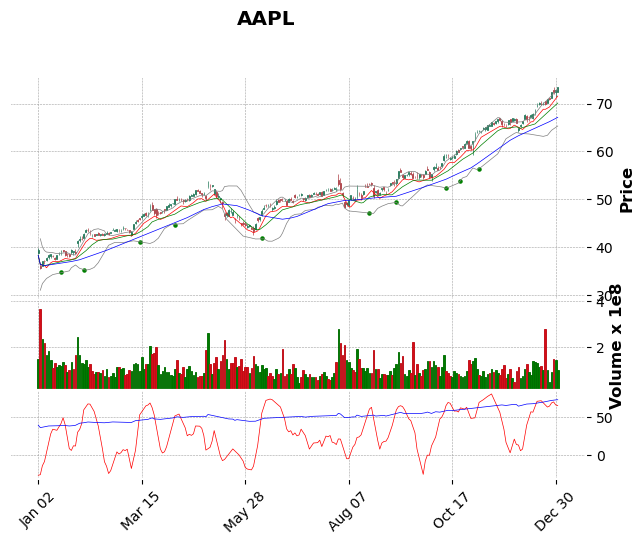

In [1582]:
ap0 = [ 
        mpf.make_addplot(every_stock['AAPL']['Upper Band'],color='grey'),  
        mpf.make_addplot(every_stock['AAPL']['Lower Band'],color='grey'),  
        mpf.make_addplot(every_stock['AAPL']['MA-4'],color='red'),
        mpf.make_addplot(every_stock['AAPL']['MA-10'],color='green'),
        mpf.make_addplot(every_stock['AAPL']['MA-30'],color='blue'),
        mpf.make_addplot(every_stock['AAPL']['Fast Stochastic'],color='r',panel=2),  
        mpf.make_addplot(every_stock['AAPL']['Slow Stochastic'],color='b',panel=2),
        mpf.make_addplot(every_stock['AAPL']['Green Dot?'],type='scatter', color='g', markersize=5)   
      ]
      
mpf.plot(every_stock['AAPL'],title='AAPL',type='candle', style='charles',volume=True,addplot=ap0,scale_width_adjustment=dict(ohlc=2.0,lines=0.4))


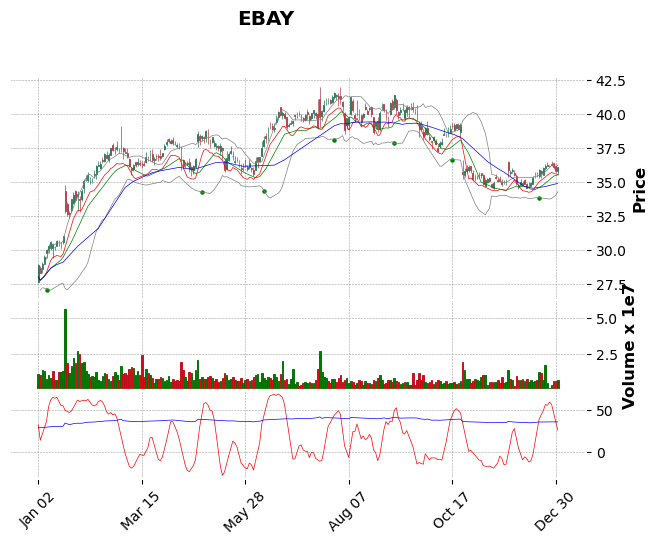

In [1569]:
ap0 = [ 
        mpf.make_addplot(every_stock['EBAY']['Upper Band'],color='grey'),  
        mpf.make_addplot(every_stock['EBAY']['Lower Band'],color='grey'),  
        mpf.make_addplot(every_stock['EBAY']['MA-4'],color='red'),
        mpf.make_addplot(every_stock['EBAY']['MA-10'],color='green'),
        mpf.make_addplot(every_stock['EBAY']['MA-30'],color='blue'),
        mpf.make_addplot(every_stock['EBAY']['Fast Stochastic'],color='r',panel=2),  
        mpf.make_addplot(every_stock['EBAY']['Slow Stochastic'],color='b',panel=2),
        mpf.make_addplot(every_stock['EBAY']['Green Dot?'],type='scatter', color='g', markersize=5),
      ]

mpf.plot(every_stock['EBAY'],title= 'EBAY',type='candle', style='charles',volume=True,addplot=ap0,scale_width_adjustment=dict(ohlc=2.0,lines=0.4))

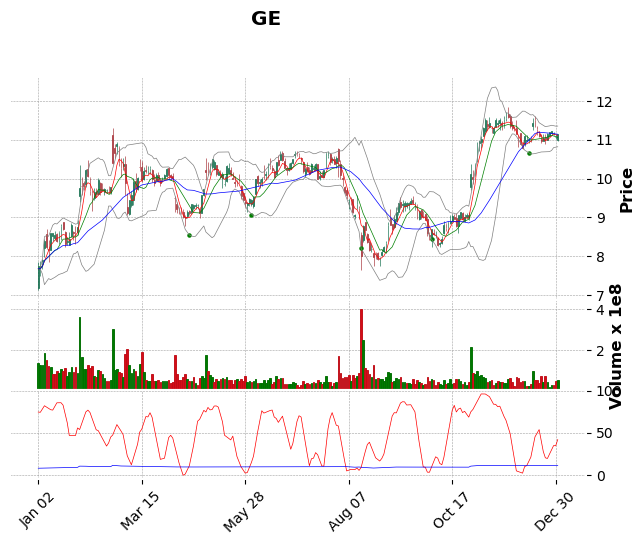

In [1570]:
ap0 = [ 
        mpf.make_addplot(every_stock['GE']['Upper Band'],color='grey'),  
        mpf.make_addplot(every_stock['GE']['Lower Band'],color='grey'),  
        mpf.make_addplot(every_stock['GE']['MA-4'],color='red'),
        mpf.make_addplot(every_stock['GE']['MA-10'],color='green'),
        mpf.make_addplot(every_stock['GE']['MA-30'],color='blue'),
        mpf.make_addplot(every_stock['GE']['Fast Stochastic'],color='r',panel=2),  
        mpf.make_addplot(every_stock['GE']['Slow Stochastic'],color='b',panel=2),
        mpf.make_addplot(every_stock['GE']['Green Dot?'],type='scatter', color='g', markersize=5),
      ]

mpf.plot(every_stock['GE'],title= 'GE',type='candle', style='charles',volume=True,addplot=ap0,scale_width_adjustment=dict(ohlc=2.0,lines=0.4))

Here is an example of a Red White Blue Chart, this design came from Dr. Eric Wish at https://wishingwealthblog.com/.
It plots slow and fast exponential moving averages to show general trends of a stock's path. Red being the fast averages (3,5,8,10,12,15) and blue being the slow ones (30,35,40,45,50,60). This chart gets its name by the pattern it makes when someone might want to buy the stock. If you observe all the red moving averages above all the blue ones, the stock is in a Red White Blue uptrend, this is a buy indicator. The opposite is when the blue is above the red, which signals a Blue White Red downtrend.

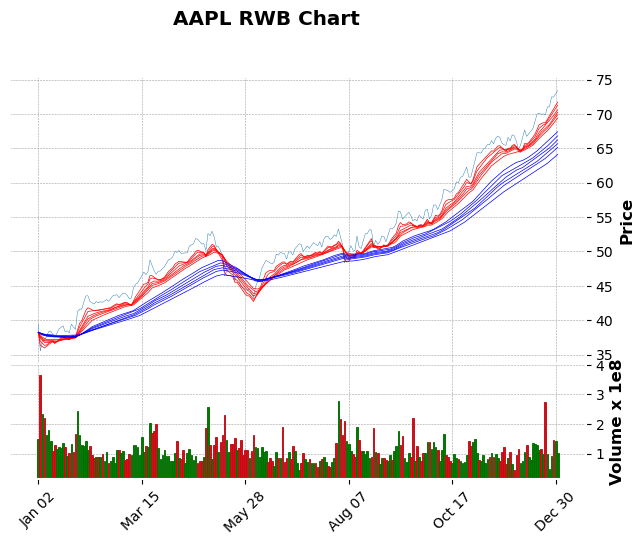

In [1597]:
ap0 = [ 
        mpf.make_addplot(every_stock['AAPL']['Ema_3'],color='red'),  
        mpf.make_addplot(every_stock['AAPL']['Ema_5'],color='red'),  
        mpf.make_addplot(every_stock['AAPL']['Ema_8'],color='red'),
        mpf.make_addplot(every_stock['AAPL']['Ema_10'],color='red'),
        mpf.make_addplot(every_stock['AAPL']['Ema_12'],color='red'),
        mpf.make_addplot(every_stock['AAPL']['Ema_15'],color='red'),  
        mpf.make_addplot(every_stock['AAPL']['Ema_30'],color='blue'),
        mpf.make_addplot(every_stock['AAPL']['Ema_35'],color='blue'),
        mpf.make_addplot(every_stock['AAPL']['Ema_40'],color='blue'),
        mpf.make_addplot(every_stock['AAPL']['Ema_45'],color='blue'),  
        mpf.make_addplot(every_stock['AAPL']['Ema_50'],color='blue'),
        mpf.make_addplot(every_stock['AAPL']['Ema_60'],color='blue'),
      ]

mpf.plot(every_stock['AAPL'],title= 'AAPL RWB Chart',type='line', style='charles',volume=True,addplot=ap0,scale_width_adjustment=dict(ohlc=2.0,lines=0.4))

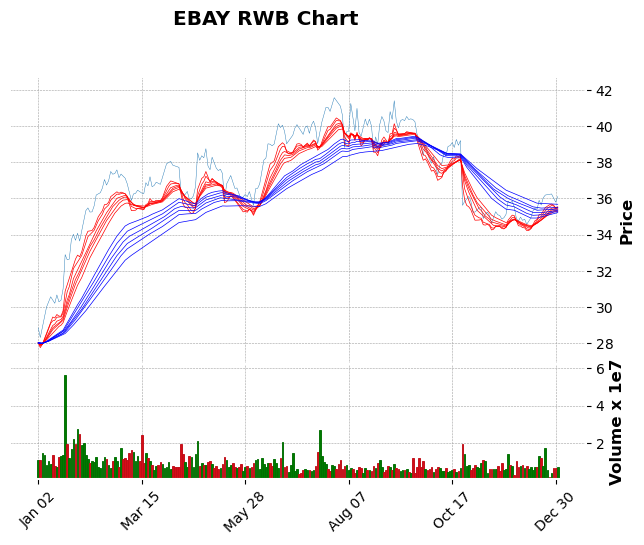

In [1595]:
ap0 = [ 
        mpf.make_addplot(every_stock['EBAY']['Ema_3'],color='red'),  
        mpf.make_addplot(every_stock['EBAY']['Ema_5'],color='red'),  
        mpf.make_addplot(every_stock['EBAY']['Ema_8'],color='red'),
        mpf.make_addplot(every_stock['EBAY']['Ema_10'],color='red'),
        mpf.make_addplot(every_stock['EBAY']['Ema_12'],color='red'),
        mpf.make_addplot(every_stock['EBAY']['Ema_15'],color='red'),  
        mpf.make_addplot(every_stock['EBAY']['Ema_30'],color='blue'),
        mpf.make_addplot(every_stock['EBAY']['Ema_35'],color='blue'),
        mpf.make_addplot(every_stock['EBAY']['Ema_40'],color='blue'),
        mpf.make_addplot(every_stock['EBAY']['Ema_45'],color='blue'),  
        mpf.make_addplot(every_stock['EBAY']['Ema_50'],color='blue'),
        mpf.make_addplot(every_stock['EBAY']['Ema_60'],color='blue'),
      ]

mpf.plot(every_stock['EBAY'],title= 'EBAY RWB Chart',type='line', style='charles',volume=True,addplot=ap0,scale_width_adjustment=dict(ohlc=2.0,lines=0.4))

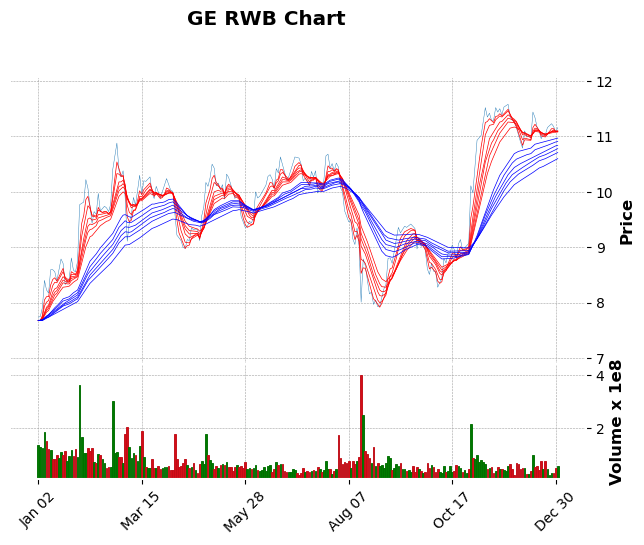

In [1596]:
ap0 = [ 
        mpf.make_addplot(every_stock['GE']['Ema_3'],color='red'),  
        mpf.make_addplot(every_stock['GE']['Ema_5'],color='red'),  
        mpf.make_addplot(every_stock['GE']['Ema_8'],color='red'),
        mpf.make_addplot(every_stock['GE']['Ema_10'],color='red'),
        mpf.make_addplot(every_stock['GE']['Ema_12'],color='red'),
        mpf.make_addplot(every_stock['GE']['Ema_15'],color='red'),  
        mpf.make_addplot(every_stock['GE']['Ema_30'],color='blue'),
        mpf.make_addplot(every_stock['GE']['Ema_35'],color='blue'),
        mpf.make_addplot(every_stock['GE']['Ema_40'],color='blue'),
        mpf.make_addplot(every_stock['GE']['Ema_45'],color='blue'), 
        mpf.make_addplot(every_stock['GE']['Ema_50'],color='blue'),
        mpf.make_addplot(every_stock['GE']['Ema_60'],color='blue'),
      ]

mpf.plot(every_stock['GE'],title= 'GE RWB Chart',type='line', style='charles',volume=True,addplot=ap0,scale_width_adjustment=dict(ohlc=2.0,lines=0.4))

## Explaining GMI:

The GMI is short for General Market Index, its properties are as followed:




The GMI is used to hypothesize whether the general market is in an up or down trend. It is green when at least 3 of these properties are fufilled. It is taken again from Dr. Eric Wish at https://wishingwealthblog.com/. Dr. Wish uses this indicator in order to prevent more loss than is needed. He is in cash when the GMI flashes Red. Later in the project I will compare a portfolio traded with all the indicators and not the GMI and one with the GMI to see if it helps mitigate loss.

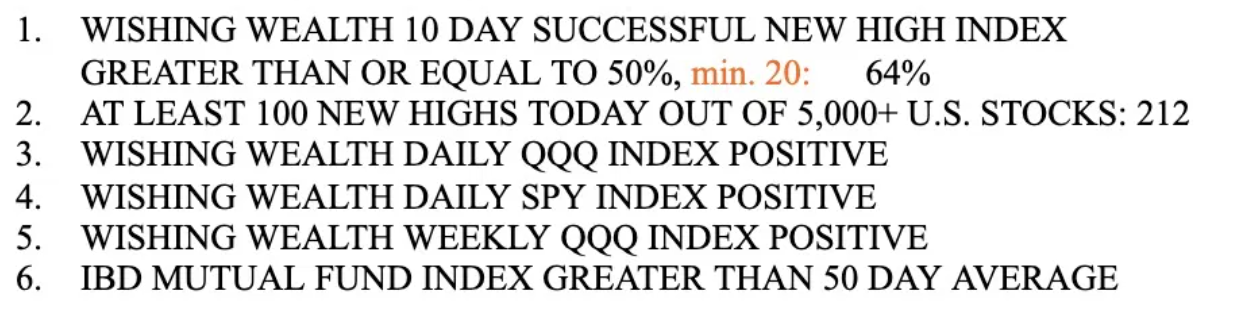

In [1607]:
Image(filename="GMI.png", width= 600, height=500)

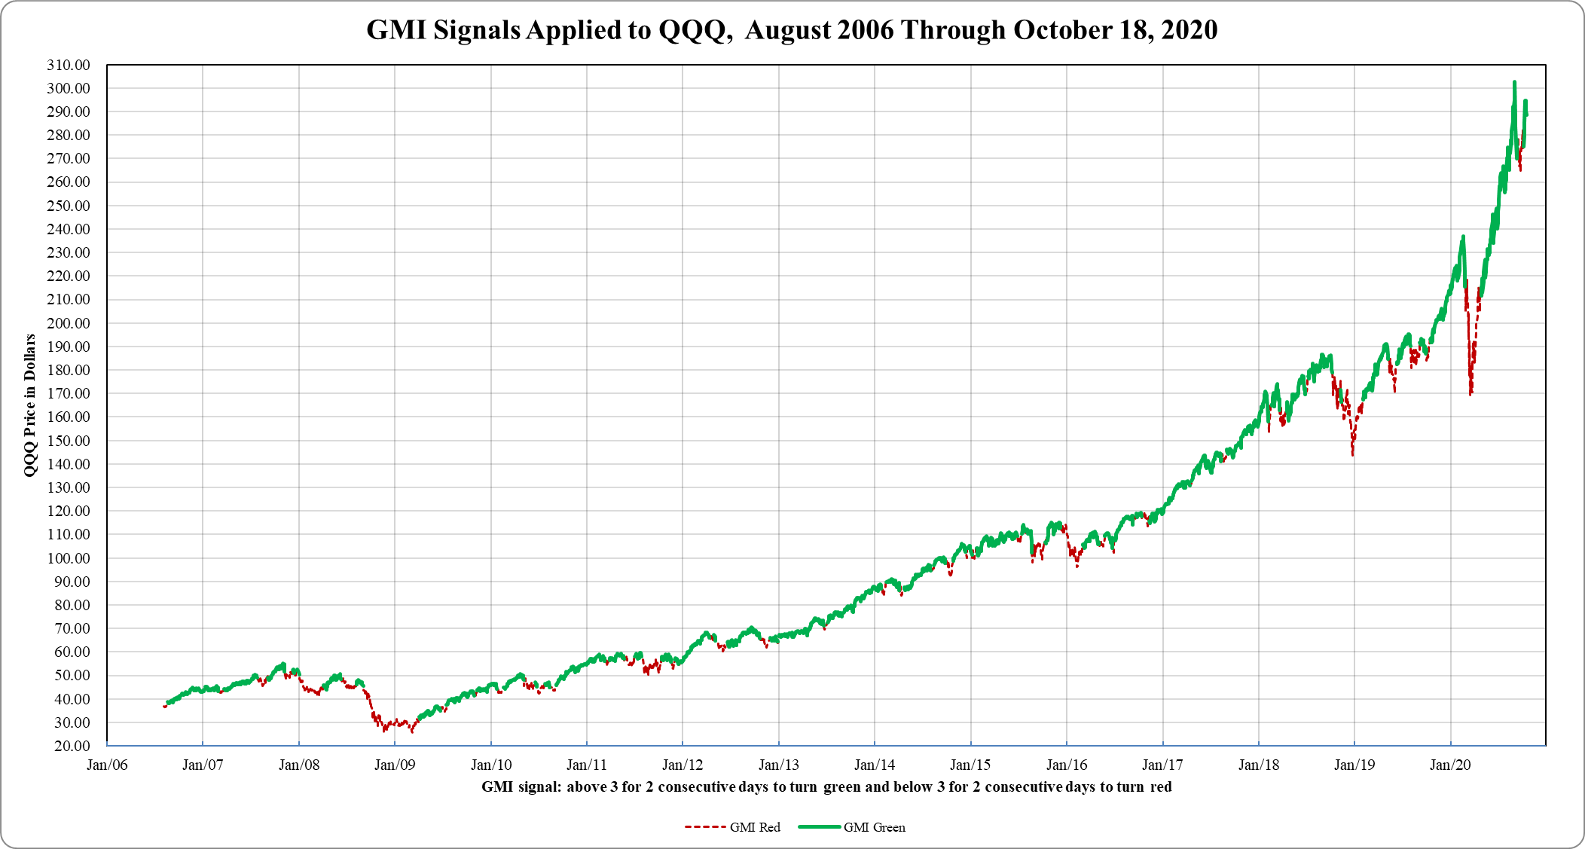

In [1608]:
Image(filename="GMIpng.png", width= 700, height=600)

These functions take all the indicators given by the dateframe per day and decide if they want to buy/sell/hold that stock today.  The difference between the two is that the buy_sell_with_GMI() function only trades when the GMI is green and sells everything when it flashes red.<br><br>

The indicators for both are the same except for the GMI in the second function, but both functions buy a stock when it has a green dot on that day, the stock is in a Red White Blue uptrend, the amount of stocks in the portfolio is less than the maximum we have assigned, and the do_ML function on the current stock is above a confidence of 0.7. <br><br>

A stock is sold only when its chart switches from a Red White Blue uptrend to a Blue White Red downtrend, the GMI at the current date is red (only for the second function), or the end of the year has been reached because we want to see the amount the portfolio gained or lossed throughout the year.

In [1587]:
import datetime

def buy_sell(total_fund, stock, date, num_shares, num_stocks_held, stocks_owned, shares_bought, max_stocks):
    date_time_str = '2019-12-31 00:00:00'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    df = every_stock[stock]
    if df['Color Chart'][date] == 'RWB' and df['Green Dot?'][date] == df['Lower Band'][date] and not (stock in stocks_owned) and total_fund != 0 and len(stocks_owned) < max_stocks and date != date_time_obj and do_ML(stock) > 0.7:
        print("\nBuying " + str(stock) + " at: " + str(date) + "\n" + str(num_shares) + " shares\n" + str(df['Open'][date]) + " per share")
        return 2
    if df['Color Chart'][date] == 'BWR' and (stock in stocks_owned):
        print("\nSelling " + str(stock) + " becasue of BWR: " + str(date)  + "\n" + str(shares_bought[stocks_owned.index(str(stock))]) + " shares\n" + str(df['Adj Close'][date]) + " per share")
        return 1
    if date == date_time_obj and (stock in stocks_owned):
        print("\nSelling " + str(stock) + " at end of year at " + str(df['Adj Close'][date]) + " per share" + " for " + str((shares_bought[stocks_owned.index(str(stock))] * df['Adj Close'][date])))
        return 3
    else: 
        return 0



def buy_sell_with_GMI(total_fund, stock, date, num_shares, num_stocks_held, stocks_owned, shares_bought, max_stocks):
    date_time_str = '2019-12-31 00:00:00'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    df = every_stock[stock]
    if df['Color Chart'][date] == 'RWB' and df['GMI'][date] == 'Green' and df['Green Dot?'][date] == df['Lower Band'][date] and not (stock in stocks_owned) and total_fund != 0 and len(stocks_owned) < max_stocks and date != date_time_obj and do_ML(stock) > 0.7:
        print("\nBuying " + str(stock) + " at: " + str(date) + "\n" + str(num_shares) + " shares\n" + str(df['Open'][date]) + " per share")
        return 2
    if df['Color Chart'][date] == 'BWR' and (stock in stocks_owned):
        print("\nSelling " + str(stock) + " becasue of BWR: " + str(date)  + "\n" + str(shares_bought[stocks_owned.index(str(stock))]) + " shares\n" + str(df['Adj Close'][date]) + " per share")
        return 1
    if df['GMI'][date] == 'Red' and (stock in stocks_owned):
        print("\nSelling " + str(stock) + " becasue of red GMI: " + str(date)  + "\n" + str(shares_bought[stocks_owned.index(str(stock))]) + " shares\n" + str(df['Adj Close'][date]) + " per share")
        return 1
    if date == date_time_obj and (stock in stocks_owned):
        print("\nSelling " + str(stock) + " at end of year at " + str(df['Adj Close'][date]) + " per share" + " for " + str((shares_bought[stocks_owned.index(str(stock))] * df['Adj Close'][date])))
        return 3
    else: 
        return 0


These functions manage the portfolio at every day and add or subtract from the portfolio if a stock is bought or sold with the buy_sell or buy_sell_with_GMI functions.

In [1588]:
def trade(portfolio, original_p, date, df, stocks_owned, shares_bought, num_stocks_held, max_stocks, ticker):
    num_stocks_held = len(stocks_owned) 

    if (((original_p / max_stocks) / df['Open'][date]) > 0.0): 
        if portfolio > (original_p / max_stocks):
            num_shares = ((original_p / max_stocks) / df['Open'][date]) 
        else:
            num_shares = portfolio / df['Open'][date]
    
    buy_sell_hold = buy_sell(portfolio, ticker, date, num_shares, num_stocks_held, stocks_owned, shares_bought, max_stocks)

    if buy_sell_hold == 2 and len(stocks_owned) <= max_stocks:
        print("Portfolio Value before buying " + str(ticker) + " = " + str(portfolio))
        stocks_owned.append(ticker)
        shares_bought.append(num_shares)
        s = (shares_bought[stocks_owned.index(str(ticker))])
        portfolio = portfolio - (s * df['Open'][date])
        print("Portfolio Value after buying " + str(ticker) + " = " + str(portfolio))
        return portfolio
    elif buy_sell_hold == 1 and (ticker in stocks_owned):
        portfolio = portfolio + (shares_bought[stocks_owned.index(str(ticker))] * df['Adj Close'][date])
        shares_bought.remove(shares_bought[stocks_owned.index(str(ticker))])
        stocks_owned.remove(str(ticker))
        print("Portfolio value = " + str(portfolio))
        return portfolio
    elif buy_sell_hold == 3 and (ticker in stocks_owned):
        portfolio = portfolio + (shares_bought[stocks_owned.index(str(ticker))] * df['Adj Close'][date])
        shares_bought.remove(shares_bought[stocks_owned.index(str(ticker))])
        stocks_owned.remove(str(ticker))
        print("Portfolio value = " + str(portfolio))
        return portfolio
    else:
        return portfolio


def trade_with_GMI(portfolio, original_p, date, df, stocks_owned, shares_bought, num_stocks_held, max_stocks, ticker):
    num_stocks_held = len(stocks_owned) 

    if (((original_p / max_stocks) / df['Open'][date]) > 0.0): 
        if portfolio > (original_p / max_stocks):
            num_shares = ((original_p / max_stocks) / df['Open'][date]) 
        else:
            num_shares = portfolio / df['Open'][date]
    
    buy_sell_hold = buy_sell_with_GMI(portfolio, ticker, date, num_shares, num_stocks_held, stocks_owned, shares_bought, max_stocks)

    if buy_sell_hold == 2 and len(stocks_owned) <= max_stocks:
        print("Portfolio Value before buying " + str(ticker) + " = " + str(portfolio))
        stocks_owned.append(ticker)
        shares_bought.append(num_shares)
        s = (shares_bought[stocks_owned.index(str(ticker))])
        portfolio = portfolio - (s * df['Open'][date])
        print("Portfolio Value after buying " + str(ticker) + " = " + str(portfolio))
        return portfolio
    elif buy_sell_hold == 1 and (ticker in stocks_owned):
        portfolio = portfolio + (shares_bought[stocks_owned.index(str(ticker))] * df['Adj Close'][date])
        shares_bought.remove(shares_bought[stocks_owned.index(str(ticker))])
        stocks_owned.remove(str(ticker))
        print("Portfolio value = " + str(portfolio))
        return portfolio
    elif buy_sell_hold == 3 and (ticker in stocks_owned):
        portfolio = portfolio + (shares_bought[stocks_owned.index(str(ticker))] * df['Adj Close'][date])
        shares_bought.remove(shares_bought[stocks_owned.index(str(ticker))])
        stocks_owned.remove(str(ticker))
        print("Portfolio value = " + str(portfolio))
        return portfolio
    else:
        return portfolio
        




These functions take in paramaters of the portfolio value at the beginning of the year and the max amount of stocks we want to hold at one time. They then call either buy_sell or buy_sell_with_GMI and return the final portfolio value of the year and the percent gained/lossed. The max stocks in the portfolio at a time also cooresponds to the fraction of money that stock can take up in the portfolio. For example, with a hypothetical portfolio value of 36,000 the simulation with 6 as the maximum amount of stocks in the portfolio at a time, will invest 6,000 per stock at the beginning to keep the portfolio diversified. <br><br>

With regard to fractional shares, I am allowing them becasue a number of online stock brokers such as Robinhood allow their investors to buy fractions of shares.

In [1589]:
def run_simulation(portfolio, max_stocks):
    original_p = portfolio

    stocks_owned = []
    shares_bought = []
    stocks_processed = []
    num_stocks_held = 0
    dates = []

    df = every_stock['AAPL']
    for date in df.index:
        dates.append(date)

    for date in dates:
        for stock in every_stock:
            if date >= every_stock[stock].index[0]:
                ticker = stock
                portfolio = trade(portfolio, original_p, date, every_stock[stock], stocks_owned, shares_bought, num_stocks_held, max_stocks, ticker)

    print("\n")
    print("Final portfolio value: " + str(portfolio))
    if original_p > portfolio:
        print("Percent made in the year: " + "-" + str((1 - (portfolio / original_p)) * 100) + "%")
    else:
        print("Percent made in the year: " + str(100 * ((portfolio / original_p) -1)) + "%")



def run_simulation_with_GMI(portfolio, max_stocks):
    original_p = portfolio
    stocks_owned = []
    shares_bought = []
    stocks_processed = []
    num_stocks_held = 0
    dates = []
    df = every_stock['AAPL']
    for date in df.index:
        dates.append(date)

    for date in dates:
        
        for stock in every_stock:
     
            if date >= every_stock[stock].index[0]:
                ticker = stock
                portfolio = trade_with_GMI(portfolio, original_p, date, every_stock[stock], stocks_owned, shares_bought, num_stocks_held, max_stocks, ticker)

    print("\n")
    print("Final portfolio value: " + str(portfolio))
    if original_p > portfolio:
        print("Percent made in the year: " + "-" + str((1 - (portfolio / original_p)) * 100) + "%")
    else:
        print("Percent made in the year: " + str(100 * ((portfolio / original_p) -1)) + "%")
    

This method call runs the simulation of buying and selling the S&P 500 stocks in 2019 and returns how well it did. We give the portfolio $100,000 and a maximum amount of stocks we are allowing it at a time. I have determind that having the max stocks set to 6 in the portfolio at a time grants the most gains overall to the portfolio.

In [1601]:
run_simulation(100000.0, 6)

Data spread:  Counter({'0': 202, '1': 26, '-1': 24})

Buying DVA at: 2019-01-04 00:00:00
321.6261436669081 shares
51.81999969482422 per share
Portfolio Value before buying DVA = 100000.0
Portfolio Value after buying DVA = 83333.33333333333
Data spread:  Counter({'0': 219, '1': 17, '-1': 16})

Buying XRAY at: 2019-01-04 00:00:00
438.5964912280702 shares
38.0 per share
Portfolio Value before buying XRAY = 83333.33333333333
Portfolio Value after buying XRAY = 66666.66666666666
Data spread:  Counter({'0': 225, '1': 17, '-1': 10})

Buying HOLX at: 2019-01-04 00:00:00
435.5021287512311 shares
38.27000045776367 per share
Portfolio Value before buying HOLX = 66666.66666666666
Portfolio Value after buying HOLX = 49999.999999999985
Data spread:  Counter({'0': 217, '1': 18, '-1': 17})

Buying MNST at: 2019-01-04 00:00:00
343.5717840309318 shares
48.5099983215332 per share
Portfolio Value before buying MNST = 49999.999999999985
Portfolio Value after buying MNST = 33333.333333333314
Data spread:  C

This method call does the same as the one above, but it runs the simulation if we only buy stocks when the GMI is green and sell them all when it turns red. 

In [1591]:
run_simulation_with_GMI(100000.0,6)

Data spread:  Counter({'0': 200, '1': 30, '-1': 22})

Buying DHI at: 2019-02-01 00:00:00
432.3389622961121 shares
38.54999923706055 per share
Portfolio Value before buying DHI = 100000.0
Portfolio Value after buying DHI = 83333.33333333333
Data spread:  Counter({'0': 224, '1': 16, '-1': 12})

Buying AES at: 2019-02-04 00:00:00
1001.0010239350303 shares
16.649999618530273 per share
Portfolio Value before buying AES = 83333.33333333333
Portfolio Value after buying AES = 66666.66666666666
Data spread:  Counter({'0': 222, '1': 17, '-1': 13})

Buying AKAM at: 2019-02-04 00:00:00
254.10379016957683 shares
65.58999633789061 per share
Portfolio Value before buying AKAM = 66666.66666666666
Portfolio Value after buying AKAM = 49999.999999999985
Data spread:  Counter({'0': 214, '1': 23, '-1': 15})

Buying AAPL at: 2019-02-04 00:00:00
398.2239125997679 shares
41.852500915527344 per share
Portfolio Value before buying AAPL = 49999.999999999985
Portfolio Value after buying AAPL = 33333.333333333314


## In conclusion:




The S&P 500 when put through the simulation without the GMI indicator made an on average 31-34% gain on the original portfolio value of $100,000. This compared to the simulation with the GMI indicator making between 2-6% on the year is a huge imporvement. While the GMI does help protect against big losses, it loses big gains too because it forces us to sell a stock that is going going up just because it deems the market to be in a down trend.<br> 

As stated at the beginning, the S&P 500 in 2019 went up in value by 29%, so in our simulation without the GMI indicator our portfolio beat the S&P 500 by up to 5%.<br>

This trading strategy then seems viable and effective in the real world to deploy on ones portfolio, and more interestingly shows that even with no fundamental data about each stock ie. net value or how they are viewed by the public, we still were able to beat the market.<br>

